In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,roc_curve,auc
data=pd.read_csv("D:/从c盘转移的桌面/github/Python Financial Engineering/Financial Engineering Project6/Bcard.txt")
train = data[data.obs_mth != '2018-11-30'].reset_index().copy()
val = data[data.obs_mth == '2018-11-30'].reset_index().copy()
feature_lst = ['person_info','finance_info','credit_info','act_info']
import numpy as np

In [2]:
x = train[feature_lst]
y = train['bad_ind']

val_x =  val[feature_lst]
val_y = val['bad_ind']

In [3]:
lr_model = LogisticRegression(C=0.1,class_weight='balanced')
lr_model.fit(x,y)
y_pred = lr_model.predict_proba(x)[:,1]

In [4]:
fpr_lr_train,tpr_lr_train,_ = roc_curve(y,y_pred)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ',train_ks)

train_ks :  0.4482325608488951


In [5]:
y_pred = lr_model.predict_proba(val_x)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(val_y,y_pred)
val_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ',val_ks)

val_ks :  0.4198642457760936


In [6]:
from pyod.models.iforest import IForest
clf = IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=1.0,
                max_samples='auto', n_estimators=500, n_jobs=-1, random_state=None,verbose=0)
clf.fit(x)

IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=500, n_jobs=-1, random_state=None,
    verbose=0)

In [7]:
out_pred = clf.predict_proba(x,method ='linear')[:,1]
train['out_pred'] = out_pred


c:\Users\HUAWEI\anaconda3\envs\risk_ctrl\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [8]:
x = train[train.out_pred< 0.7][feature_lst]#Filter the data using IForest
y = train[train.out_pred < 0.7]['bad_ind']

val_x =  val[feature_lst]
val_y = val['bad_ind']

In [9]:
lr_model = LogisticRegression(C=0.1,class_weight='balanced')
lr_model.fit(x,y)
y_pred = lr_model.predict_proba(x)[:,1]
fpr_lr_train,tpr_lr_train,_ = roc_curve(y,y_pred)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('Iforest with balanced Logistic train_ks : ',train_ks)

Iforest with balanced Logistic train_ks :  0.42324747765706233


In [10]:
y_pred = lr_model.predict_proba(val_x)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(val_y,y_pred)
val_ks = abs(fpr_lr - tpr_lr).max()
print('Iforest with balanced Logistic val_ks : ',val_ks)

Iforest with balanced Logistic val_ks :  0.42960019609463046


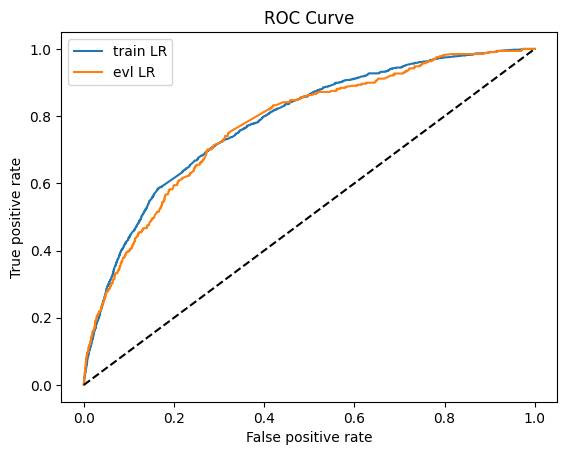

In [11]:
from matplotlib import pyplot as plt
plt.plot(fpr_lr_train,tpr_lr_train,label = 'train LR')
plt.plot(fpr_lr,tpr_lr,label = 'evl LR')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc = 'best')
plt.show()


In [12]:
train['for_pred'] = np.where(train.out_pred>0.7,1,0)
print(train.for_pred.groupby(train.obs_mth).mean())
print(train.groupby('for_pred')['bad_ind'].sum()/train.groupby('for_pred')['bad_ind'].count())

obs_mth
2018-06-30    0.018575
2018-07-31    0.012107
2018-09-30    0.035204
2018-10-31    0.029394
Name: for_pred, dtype: float64
for_pred
0    0.016349
1    0.119524
Name: bad_ind, dtype: float64


In [13]:
y_pred = clf.predict_proba(x,method ='linear')[:,1]#using the model from clf once again
fpr_lr_train,tpr_lr_train,_ = roc_curve(y,y_pred)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ',train_ks)

c:\Users\HUAWEI\anaconda3\envs\risk_ctrl\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


train_ks :  0.3224221681492328


In [14]:
y_pred = clf.predict_proba(val_x,method ='linear')[:,1]
fpr_lr,tpr_lr,_ = roc_curve(val_y,y_pred)
val_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ',val_ks)

c:\Users\HUAWEI\anaconda3\envs\risk_ctrl\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


val_ks :  0.3088028641039271


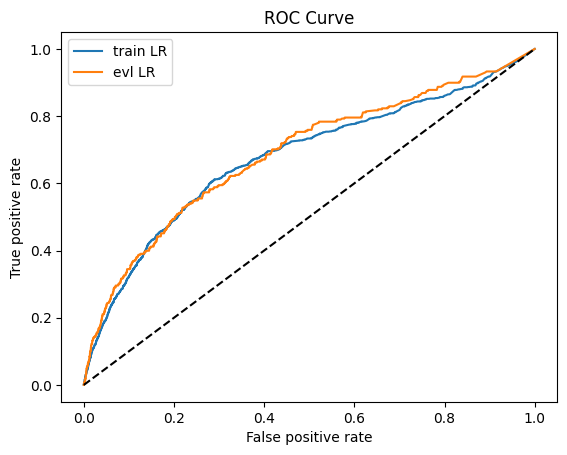

In [15]:
from matplotlib import pyplot as plt
plt.plot(fpr_lr_train,tpr_lr_train,label = 'train LR')
plt.plot(fpr_lr,tpr_lr,label = 'evl LR')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc = 'best')
plt.show()

In [16]:
import math
model=clf
bins=20
temp_=pd.DataFrame()
temp_['bad_rate_predict']=[s[1] for s in model.predict_proba(val_x)]#Put the second predicted result in a separate column
temp_['real_bad']=val_y
temp_=temp_.sort_values('bad_rate_predict',ascending=False)
temp_['num']=[i for i in range(temp_.shape[0])]
temp_['num']=pd.cut(temp_.num,bins=bins,labels=[i for i in range(bins)])

c:\Users\HUAWEI\anaconda3\envs\risk_ctrl\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [17]:
report=pd.DataFrame()
report['BAD']=temp_.groupby('num').real_bad.sum().astype(int)
report['GOOD']=temp_.groupby('num').real_bad.count().astype(int)-report['BAD']
report['BAD_CNT']=report['BAD'].cumsum()
report['GOOD_CNT']=report['GOOD'].cumsum()

In [18]:
good_total=report.GOOD_CNT.max()
bad_total=report.BAD_CNT.max()
report['BAD_PCTG']=round(report.BAD_CNT/bad_total,3)
report['BADRATE']=report.apply(lambda x:round(x.BAD/(x.BAD+x.GOOD),3),axis=1)

In [19]:
def cal_ks(x):
    ks=(x.BAD_CNT/bad_total)-(x.GOOD_CNT/good_total)
    return round(math.fabs(ks),3)
report['KS']=report.apply(cal_ks,axis=1)

In [20]:
model = clf
row_num, col_num = 0, 0
bins = 20
Y_predict = [s[1] for s in model.predict_proba(val_x)]
Y = val_y
nrows = Y.shape[0]
lis = [(Y_predict[i], Y[i]) for i in range(nrows)]
ks_lis = sorted(lis, key=lambda x: x[0], reverse=True)#Sort the list of tuples using this method
print(lis)
print(ks_lis)

c:\Users\HUAWEI\anaconda3\envs\risk_ctrl\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


[(0.7603668904869892, 0.0), (0.07898159144972461, 0.0), (0.17393811013713512, 0.0), (0.5539572539494474, 0.0), (0.07898159144972461, 0.0), (0.7109777712137824, 0.0), (0.34621694965235517, 0.0), (0.17844692344813867, 0.0), (0.014240411918253593, 0.0), (0.29517258078599784, 0.0), (0.05597702313088593, 0.0), (0.014240411918253593, 0.0), (0.13656644851120742, 0.0), (0.07419466304780459, 0.0), (0.05024910662538423, 0.0), (0.17393811013713512, 0.0), (0.06097767401204374, 0.0), (0.009236536097300907, 0.0), (0.17393811013713512, 0.0), (0.05526166220869738, 0.0), (0.056914019935898674, 0.0), (0.2548820110854235, 0.0), (0.1831200941466778, 0.0), (0.3989987180769232, 0.0), (0.09390418062679085, 0.0), (0.07419466304780459, 0.0), (0.3123499672478366, 0.0), (0.06097767401204374, 0.0), (0.6304871229351882, 0.0), (0.06097767401204374, 0.0), (0.5413066438853775, 0.0), (0.10353709346312923, 0.0), (0.35939405091456983, 0.0), (0.09775900574624619, 0.0), (0.18548998744343187, 0.0), (0.2161332962413631, 0.0

In [21]:
bin_num=int(nrows/bins+1)
bad=sum([1 for (p,y) in ks_lis if y>0.5])#Count the number of true values greater than 0.5
good=sum([1 for (p,y) in ks_lis if y<=0.5])
bad_cnt,good_cnt=0,0

In [22]:
KS = []
BAD = []
GOOD = []
BAD_CNT = []
GOOD_CNT = []
BAD_PCTG = []
BADRATE = []
dct_report = {}

In [23]:
for j in range(bins):
    ds=ks_lis[j*bin_num:min((j+1)*bin_num,nrows)]#get the data from each box
    bad1=sum([1 for (p,y) in ds if y>0.5])#get the data from box which true values greater than 0.5
    good1=sum([1 for (p,y) in ds if y<=0.5])
    bad_cnt+=bad1
    good_cnt+= good1
    bad_pctg=round(bad_cnt/sum(val_y),3)
    badrate=round(bad1/(bad1+good1),3)#calculate bad rate
    ks= round(math.fabs((bad_cnt/bad)-(good_cnt/good)),3)
    KS.append(ks)
    BAD.append(bad1)
    GOOD.append(good1)
    BAD_CNT.append(bad_cnt)
    GOOD_CNT.append(good_cnt)
    BAD_PCTG.append(bad_pctg)
    BADRATE.append(badrate)
    dct_report['KS'] = KS
    dct_report['BAD'] = BAD
    dct_report['GOOD'] = GOOD
    dct_report['BAD_CNT'] = BAD_CNT
    dct_report['GOOD_CNT'] = GOOD_CNT
    dct_report['BAD_PCTG'] = BAD_PCTG
    dct_report['BADRATE'] = BADRATE
val_report=pd.DataFrame(dct_report)
print(val_report)

       KS  BAD  GOOD  BAD_CNT  GOOD_CNT  BAD_PCTG  BADRATE
0   0.176   73   726       73       726     0.223    0.091
1   0.240   37   762      110      1488     0.335    0.046
2   0.255   21   778      131      2266     0.399    0.026
3   0.294   29   770      160      3036     0.488    0.036
4   0.305   20   779      180      3815     0.549    0.025
5   0.294   13   786      193      4601     0.588    0.016
6   0.281   12   787      205      5388     0.625    0.015
7   0.273   14   785      219      6173     0.668    0.018
8   0.275   17   782      236      6955     0.720    0.021
9   0.261   12   787      248      7742     0.756    0.015
10  0.238    9   790      257      8532     0.784    0.011
11  0.200    4   795      261      9327     0.796    0.005
12  0.170    7   792      268     10119     0.817    0.009
13  0.138    6   793      274     10912     0.835    0.008
14  0.118   10   789      284     11701     0.866    0.013
15  0.095    9   790      293     12491     0.893    0.0